<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Hyperparameter tuning (Spark based recommender)

Hyperparameter tuning for Spark based recommender algorithm is important to select a model with the optimal performance. This notebook introduces good practices in performing hyperparameter tuning for building recommender models with the utility functions provided in the [Microsoft/Recommenders](https://github.com/Microsoft/Recommenders.git) repository.

Three different approaches are introduced and comparatively studied.
* Spark native constructs (`ParamGridBuilder`, `TrainValidationSplit`).
* `hyperopt` package with Tree of Parzen Estimator algorithm. 
* Parallelized random search of parameter values sampled with pre-defined space. 

## 0 Global settings and import

In [59]:
# set the environment path to find Recommenders
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")
import pandas as pd
import numpy as np
import time

import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample

from reco_utils.common.spark_utils import start_or_get_spark
from reco_utils.evaluation.spark_evaluation import SparkRankingEvaluation, SparkRatingEvaluation
from reco_utils.dataset.movielens import load_spark_df
from reco_utils.dataset.spark_splitters import spark_random_split

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("PySpark version: {}".format(pyspark.__version__))

System version: 3.6.0 | packaged by conda-forge | (default, Feb  9 2017, 14:36:55) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Pandas version: 0.23.4
PySpark version: 2.3.1


In [61]:
COL_USER = "UserId"
COL_ITEM = "MovieId"
COL_TIMESTAMP = "Timestamp"
COL_RATING = "Rating"
COL_PREDICTION = "prediction"

HEADER = {
    "col_user": COL_USER,
    "col_item": COL_ITEM,
    "col_rating": COL_RATING,
    "col_prediction": COL_PREDICTION,
}

HEADER_ALS = {
    "userCol": COL_USER,
    "itemCol": COL_ITEM,
    "ratingCol": COL_RATING
}

## 1 Data preparation

For illustration purpose, data used for demonstrating the hyperparameter tuning practices is the Movielens 100k dataset. 

In [62]:
spark = start_or_get_spark()

Movielens 100k dataset is used for running the demonstration.

In [63]:
data = load_spark_df(spark, size='100k')

The dataset is split into 3 subsets randomly with a given split ratio. The hyperparameter tuning is performed on the training and the validating data, and then the optimal recommender selected is evaluated on the testing dataset.

In [64]:
train, valid, test = spark_random_split(data, ratio=[3, 1, 1])

## 2 Hyper parameter tuning with Azure Machine Learning Services

The `hyperdrive` module in the [Azure Machine Learning Services](https://azure.microsoft.com/en-us/services/machine-learning-service/) is supposed to run [hyperparameter tuning and optimizing for machine learning model selection](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-tune-hyperparameters). At the moment, the service supports running hyperparameter tuning on heterogenous computing targets such as cluster of commodity compute nodes with or without GPU devices (see detailed documentation [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-set-up-training-targets)). It is feasible to run parameter tuning on a cluster of VM nodes. In this case, the service containerizes individual and independent Spark session on each node of the cluster to run the parameter tuning job in parallel, instead of inside a single Spark session where the training is executed in a distributed manner.  

It is worth mentioning that tuning hyperparameter with `hyperdrive` in Azure Machine Learning services will be a feature in the future version. 

Detailed instructions of tuning hyperparameter of non-Spark workloads by using Azure Machine Learning Services can be found in [this](https://github.com/Microsoft/Recommenders.git) notebook. 

## 3 Hyper parameter tuning with Spark ML constructs

Spark ML lib implements modules such as `CrossValidator` and `TrainValidationSplit` for tuning hyperparameters (see [here](https://spark.apache.org/docs/2.2.0/ml-tuning.html)). However, by default, it does not support custom machine learning algorithms, data splitting methods, and evaluation metrics, like what are offered as utility functions in the Recommenders repository. 

For example, the Spark native constuct can be used for tuning a recommender against the `rmse` metric which is one of the available regression metrics in Spark.

Firstly, a Spark ALS object needs to be created. In this case, for illustration purpose, it is an ALS model object.

In [65]:
# NOTE the parameters of interest, rank and regParam, are left unset, 
# because their values will be assigned in the parameter grid builder.
als = ALS(
    maxIter=15,
    implicitPrefs=False,
    alpha=0.1,
    coldStartStrategy='drop',
    nonnegative=False,
    **HEADER_ALS
)

Then, a parameter grid can be defined as follows. Without loss of generity, only `rank` and `regParam` are considered.

In [66]:
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [10, 20]) \
    .addGrid(als.regParam, [ 0.1, 0.01, 0.001, 0.0001, 0.00001]) \
    .build()

Given the settings above, a `TrainValidationSplit` constructor can be created for fitting the best model in the given parameter range.

In [67]:
tvs = TrainValidationSplit(
    estimator=als,
    estimatorParamMaps=paramGrid,
    # A regression evaluation method is used. 
    evaluator=RegressionEvaluator(labelCol='Rating'),
    # 80% of the data will be used for training, 20% for validation.
    # NOTE here the splitting is random. The Spark splitting utilities (e.g. chrono splitter)
    # are therefore not available here. 
    trainRatio=0.75
)

In [68]:
time_start = time.time()

# Run TrainValidationSplit, and choose the best set of parameters.
# NOTE train and valid is union because in Spark TrainValidationSplit does splitting by itself.
model = tvs.fit(train.union(valid))

time_spark = time.time() - time_start

The model parameters in the grid and the best metrics can be then returned. 

In [69]:
for idx, item in enumerate(model.getEstimatorParamMaps()):
    print('Run {}:'.format(idx))
    print('\tValidation Metric: {}'.format(model.validationMetrics[idx]))
    for key, value in item.items():
        print('\t{0}: {1}'.format(repr(key), value))

Run 0:
	Validation Metric: 0.9515946345930347
	Param(parent='ALS_47a7bd7a190c0e224174', name='rank', doc='rank of the factorization'): 10
	Param(parent='ALS_47a7bd7a190c0e224174', name='regParam', doc='regularization parameter (>= 0).'): 0.1
Run 1:
	Validation Metric: 1.1941459472027431
	Param(parent='ALS_47a7bd7a190c0e224174', name='rank', doc='rank of the factorization'): 10
	Param(parent='ALS_47a7bd7a190c0e224174', name='regParam', doc='regularization parameter (>= 0).'): 0.01
Run 2:
	Validation Metric: 1.4894967333861415
	Param(parent='ALS_47a7bd7a190c0e224174', name='rank', doc='rank of the factorization'): 10
	Param(parent='ALS_47a7bd7a190c0e224174', name='regParam', doc='regularization parameter (>= 0).'): 0.001
Run 3:
	Validation Metric: 2.014444812205512
	Param(parent='ALS_47a7bd7a190c0e224174', name='rank', doc='rank of the factorization'): 10
	Param(parent='ALS_47a7bd7a190c0e224174', name='regParam', doc='regularization parameter (>= 0).'): 0.0001
Run 4:
	Validation Metric: 

In [70]:
model.validationMetrics

[0.9515946345930347,
 1.1941459472027431,
 1.4894967333861415,
 2.014444812205512,
 2.3527002998433897,
 0.9466358955056722,
 1.2821954349473847,
 1.713734479849178,
 2.3637287644813285,
 3.000567577478747]

To get the best model, just do

In [71]:
model_best_spark = model.bestModel

## 4 Hyperparameter tuning with `hyperopt`

`hyperopt` is an open source Python package that is designed for tuning parameters for generic function with any pre-defined loss. More information about `hyperopt` can be found [here](https://github.com/hyperopt/hyperopt). `hyperopt` supports parallelization on MongoDB but not Spark. In our case, the tuning is performed in a sequential mode on a local computer.

In `hyperopt`, an *objective* function is defined for optimizing the hyper parameters. In this case, the objective is similar to that in the Spark native construct situation, which is *to the RMSE metric for an ALS recommender*. Parameters of `rank` and `regParam` are used as hyperparameters. 

The objective function shown below demonstrates a RMSE loss for an ALS recommender. 

In [72]:
# Customize an objective function
def objective(params):
    rank = params['rank']
    reg = params['reg']
    train = params['train'] 
    valid = params['valid'] 
    col_user = params['col_user'] 
    col_item = params['col_item']
    col_rating = params['col_rating'] 
    col_prediction = params['col_prediction'] 
    k = params['k']
    relevancy_method = params['relevancy_method']
    
    als = ALS(
        rank=rank,
        maxIter=15,
        implicitPrefs=False,
        alpha=0.1,
        regParam=reg,
        coldStartStrategy='drop',
        nonnegative=False,
        seed=0,
        **HEADER_ALS
    )
    
    model = als.fit(train) 
    prediction = model.transform(valid)

    rating_eval = SparkRatingEvaluation(
        valid, 
        prediction, 
        **HEADER
    )
    
    rmse = rating_eval.rmse()
    
    # Return the objective function result.
    return {
        'loss': rmse,
        'status': STATUS_OK,
        'eval_time': time.time()
    }

A search space is usually defined for hyperparameter exploration. Design of search space is empirical, and depends on the understanding of how distribution of parameter of interest affects the model performance measured by the loss function. 

In the ALS algorithm, the two hyper parameters, rank and reg, affect model performance in a way that
* The higher the rank, the better the model performance but also the higher risk of overfitting.
* The reg parameter is subject to rank and it prevents overfitting in certain way. 

Therefore, in this case, a uniform distribution and a lognormal distribution sampling spaces are used for rank and reg, respectively. A narrow search space is used for illustration purpose, that is, the range of rank is from 10 to 20, while that of reg is from $e^{-5}$ to $e^{-1}$. Together with the randomly sampled hyper parameters, other parameters use for building / evaluating the recommender, like `k`, column names, data, etc., are kept as constants.

In [73]:
# define a search space
space = {
    'rank': hp.quniform('rank', 10, 20, 5),
    'reg': hp.loguniform('reg', -5, -1),
    'train': train, 
    'valid': valid, 
    'col_user': "UserId", 
    'col_item': "MovieId", 
    'col_rating': "Rating", 
    'col_prediction': "prediction", 
    'k': 10,
    'relevancy_method': "top_k"
}

`fmin` of `hyperopt` is used for running the trials for searching optimal hyper parameters. In `hyperopt`, there are different strategies for intelligently optimize hyper parameters. For example, `hyperopt` avails [Tree of Parzen Estimators (TPE) method](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf) for searching optimal parameters, which is more efficient than random search or grid search (details can be found [here](http://hyperopt.github.io/hyperopt/)). It is claimed in the project website that Bayesian based optimization method is planned but so far it has not yet been implemented. 

The following runs the trials with the pre-defined objective function and search space. TPE is used as the optimization method. Totally there will be 10 evaluations run for searching the best parameters.

In [74]:
time_start = time.time()

# Trials for recording each iteration of the hyperparameter searching.
trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=10
)
                  
time_hyperopt = time.time() - time_start

In [75]:
trials.best_trial

{'state': 2,
 'tid': 8,
 'spec': None,
 'result': {'loss': 0.9449390043140544,
  'status': 'ok',
  'eval_time': 1546927976.2025473},
 'misc': {'tid': 8,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'rank': [8], 'reg': [8]},
  'vals': {'rank': [20.0], 'reg': [0.17042520709415865]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2019, 1, 8, 6, 12, 44, 909000),
 'refresh_time': datetime.datetime(2019, 1, 8, 6, 12, 56, 202000)}

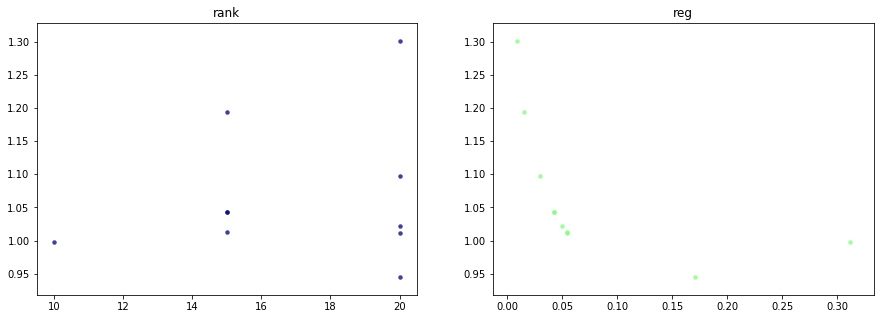

In [76]:
parameters = ['rank', 'reg']
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)

It can be seen from the above plot that
* The actual impact of rank is in line with the intuition - the larger the value the better the result.
* It is interesting to see that the optimal value of reg is ~0.1. 

Get the best model.

In [77]:
als = ALS(
    rank=best["rank"],
    regParam=best["reg"],
    maxIter=15,
    implicitPrefs=False,
    alpha=0.1,
    coldStartStrategy='drop',
    nonnegative=False,
    seed=0,
    **HEADER_ALS
)
    
model_best_hyperopt = als.fit(train)

Tuning prameters against other metrics can be simply done by modifying the `objective` function. The following shows an objective function of how to tune "precision@k". Since `fmin` in `hyperopt` only supports minimization while the actual objective of the loss is to maximize "precision@k", `-precision` instead of `precision` is used in the returned value of the `objective` function.

In [78]:
# Customize an objective function
def objective(params):
    rank = params['rank']
    reg = params['reg']
    train = params['train'] 
    valid = params['valid'] 
    col_user = params['col_user'] 
    col_item = params['col_item']
    col_rating = params['col_rating'] 
    col_prediction = params['col_prediction'] 
    k = params['k']
    relevancy_method = params['relevancy_method']
    
    header = {
        "userCol": col_user,
        "itemCol": col_item,
        "ratingCol": col_rating,
    }
    
    als = ALS(
        rank=rank,
        maxIter=15,
        implicitPrefs=False,
        alpha=0.1,
        regParam=reg,
        coldStartStrategy='drop',
        nonnegative=False,
        seed=0,
        **header
    )
    
    model = als.fit(train)
    
    users = train.select(col_user).distinct()
    items = train.select(col_item).distinct()
    user_item = users.crossJoin(items)
    dfs_pred = model.transform(user_item)

    # Remove seen items.
    dfs_pred_exclude_train = dfs_pred.alias("pred").join(
        train.alias("train"),
        (dfs_pred[col_user] == train[col_user]) & (dfs_pred[col_item] == train[col_item]),
        how='outer'
    )

    top_all = dfs_pred_exclude_train.filter(dfs_pred_exclude_train["train.Rating"].isNull()) \
        .select('pred.' + col_user, 'pred.' + col_item, 'pred.' + "prediction")
    
    top_all.cache().count()

    rank_eval = SparkRankingEvaluation(
        valid, 
        top_all, 
        k=k, 
        col_user=col_user, 
        col_item=col_item, 
        col_rating="Rating", 
        col_prediction="prediction", 
        relevancy_method=relevancy_method
    )
    
    precision = rank_eval.precision_at_k()
    
    # Return the objective function result.
    return {
        'loss': -precision,
        'status': STATUS_OK,
        'eval_time': time.time()
    }

## 5 Hyperparameter tuning with `hyperopt` sampling methods

Though `hyperopt` works well in a single node machine, its features (e.g., `Trials` module) do not support Spark environment. A good practice is to use `hyperopt` for sampling parameter values from the defined sampling space, and then parallelize the model training onto Spark cluster with the sampled parameter combinations.

The downside of this method is that the intelligent searching algorithm (i.e., TPE) of `hyperopt` cannot be used. The approach introduced here is therefore equivalent to random search.

Sample the parameters used for model building from the pre-defined space. 

In [79]:
import hyperopt.pyll.stochastic

time_start = time.time()

sample_params = [hyperopt.pyll.stochastic.sample(space) for x in range(10)]

If the master node of the Spark cluster has multiple cores, a local parallelization with Python `map` function can be used for running model building in parallel. Note here the Spark `flatMap` function cannot be used, because parallelizing Spark sessions in a Spark session is forbidden.

The following runs model building on the sampled parameter values with the pre-defined objective function.

In [80]:
results_map = list(map(lambda x: objective(x), sample_params))

time_sample = time.time() - time_start

In [81]:
results_map

[{'loss': -0.020063694267515916,
  'status': 'ok',
  'eval_time': 1546928017.7213645},
 {'loss': -0.02388535031847134,
  'status': 'ok',
  'eval_time': 1546928040.093188},
 {'loss': -0.02866242038216561,
  'status': 'ok',
  'eval_time': 1546928061.325017},
 {'loss': -0.06008492569002124,
  'status': 'ok',
  'eval_time': 1546928083.330355},
 {'loss': -0.02356687898089173,
  'status': 'ok',
  'eval_time': 1546928105.0092988},
 {'loss': -0.03227176220806794,
  'status': 'ok',
  'eval_time': 1546928126.7342896},
 {'loss': -0.0537154989384289,
  'status': 'ok',
  'eval_time': 1546928148.6456764},
 {'loss': -0.0005307855626326965,
  'status': 'ok',
  'eval_time': 1546928169.9413958},
 {'loss': -0.06188959660297242,
  'status': 'ok',
  'eval_time': 1546928191.9348536},
 {'loss': -0.053927813163481934,
  'status': 'ok',
  'eval_time': 1546928213.5259786}]

Get the best model.

In [82]:
loss_metrics = np.array([x['loss'] for x in results_map])
best_loss = np.where(loss_metrics == min(loss_metrics))

In [83]:
best_param = sample_params[best_loss[0].item()]

In [84]:
als = ALS(
    rank=best_param["rank"],
    regParam=best_param["reg"],
    maxIter=15,
    implicitPrefs=False,
    alpha=0.1,
    coldStartStrategy='drop',
    nonnegative=False,
    seed=0,
    **HEADER_ALS
)
    
model_best_sample = als.fit(train)

## 6 Evaluation on testing data

The optimal parameters can then be used for building a recommender, which is then evaluated on the testing data.

To compare the aforementioned three approaches, the evaluation metrics (loss) and the elapsed time to run each of them are recorded. 

In [85]:
# Get prediction results with the optimal modesl from different approaches.
prediction_spark = model_best_spark.transform(test)
prediction_hyperopt = model_best_hyperopt.transform(test)
prediction_sample = model_best_sample.transform(test)

predictions = [prediction_spark, prediction_hyperopt, prediction_sample]
elapsed = [time_spark, time_hyperopt, time_sample]

approaches = ['spark', 'hyperopt', 'sample']
comparison = pd.DataFrame()
for ind, approach in enumerate(approaches):    
    rating_eval = SparkRatingEvaluation(
        test, 
        predictions[ind],
        **HEADER
    )
    
    result = pd.DataFrame({
        'Approach': approach,
        'RMSE': rating_eval.rmse(),
        'MAE': rating_eval.mae(),
        'Explained variance': rating_eval.exp_var(),
        'R squared': rating_eval.rsquared(),
        'Elapsed': elapsed[ind]
    }, index=[0])
    
    comparison = comparison.append(result)

In [86]:
comparison

,Approach,RMSE,MAE,Explained variance,R squared,Elapsed
0,spark,0.920545,0.729969,0.341029,0.321293,56.728408
0,hyperopt,0.934265,0.750182,0.336724,0.300553,114.746458
0,sample,0.965644,0.761879,0.269269,0.252780,221.232502


From the results, it can be seen that, *with the same number of iterations*, Spark native construct based approach takes the least amount of time, and not suprisingly, sample based approach takes the most amount of time. Intuitively this is because Spark native constructs leverage the underlying Java codes for running the actual analytics with high performance efficiency. There is a tradeoff in choosing between `hyperopt` TPE based approach and sampling approach in a for-loop. The former uses TPE for searching optimal parameters intelligently but runs the tuning iterations sequentially, while the latter simple samples parameter values from the pre-defined space but parallelizes the runs with Python `map` function. Run-time performance of the two approaches therefore depends on acutal use cases.  

The three approaches use the same RMSE loss. In this measure, the native Spark construct performs the best. The `hyperopt` based approach performs the second best. This may be owing to the limited number of iterations used in the TPE searching algorithm. Note the differences in the RMSE metrics may also come from the randomness of the intermediate steps in parameter tuning process. In practice, multiple runs are required for generating statistically robust comparison results. We have tried 5 times for running the same comparison codes above. The results aligned well with each other in terms of objective metric values and elapsed time. 

# Conclusions

In summary, there are mainly three different approaches for running hyperparameter tuning for Spark based recommendation algorithm. The three different approaches are compared as follows.

|Approach|Distributed (on Spark)|Param sampling|Advanced hyperparam searching algo|Custom evaluation metrics|Custom data split|
|---------|-------------|--------------|--------------------------|--------------|------------|
|AML Services|Parallelizing Spark sessions on multi-node cluster or single Spark session on one VM node.)|Random, Grid, Bayesian sampling for discrete and continuous variables.|Bandit policy, Median stopping policy, and truncation selection policy.|Yes|Yes|
|Spark native construct|Distributed in single-node standalone Spark environment or multi-node Spark cluster.|No|No|No|No|
|`hyperopt`|No (only support parallelization on MongoDB)|Random sampling for discrete and continuous variables.|Tree Parzen Estimator|Yes|Yes|

# References

* Azure Machine Learning Services, url: https://azure.microsoft.com/en-us/services/machine-learning-service/
* Lisa Li, *et al*, Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization, The Journal of Machine Learning Research, Volume 18 Issue 1, pp 6765-6816, January 2017.
* James Bergstrat *et al*, Algorithms for Hyper-Parameter Optimization, Procs 25th NIPS 2011. 
* `hyperopt`, url: http://hyperopt.github.io/hyperopt/.
* Bergstra, J., Yamins, D., Cox, D. D. (2013) Making a Science of Model Search: Hyperparameter Optimization in Hundreds of Dimensions for Vision Architectures. Proc. of the 30th International Conference on Machine Learning (ICML 2013).
* Kris Wright, "Hyper parameter tuning with hyperopt", url:https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt